In [1]:
import os

import numpy as np
import pandas as pd
import datasets
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn import metrics

torch.set_float32_matmul_precision('high')
os.environ["TOKENIZERS_PARALLELISM"]="true"

In [3]:
model_name_or_path = "answerdotai/ModernBERT-base"

pipe = pipeline(
    task="text-classification", 
    model="../results/modernbert_multirc",
    tokenizer=model_name_or_path,
    device=0,
)
 
sample = "Smoking is bad for your health."
 
pipe(sample)

Device set to use cuda:0


[{'label': 'correct', 'score': 0.9971210360527039}]

In [2]:
dataset_path = "../bin/multirc_dataset.hf"

ds = datasets.DatasetDict.load_from_disk(dataset_path)

In [22]:
results = pipe(ds["test"]["text"], batch_size=8)

label2id = pipe.model.config.label2id
print(label2id)

true_labels = np.array( ds["test"]["labels"])
pred_labels = np.array([label2id[res["label"]] for res in results]) # Could also just round() the score to get integer labels
scores = np.array([res["score"] for res in results])

{'correct': 1, 'incorrect': 0}



Prediction distribution:
Unique predicted labels: (array([0, 1]), array([2250, 1712]))
Unique true labels: (array([0, 1]), array([2240, 1722]))

Accuracy: 0.7986
Precision: 0.7699
Recall: 0.7654
F1 Score: 0.7676
Confusion Matrix:
[[1846  394]
 [ 404 1318]]


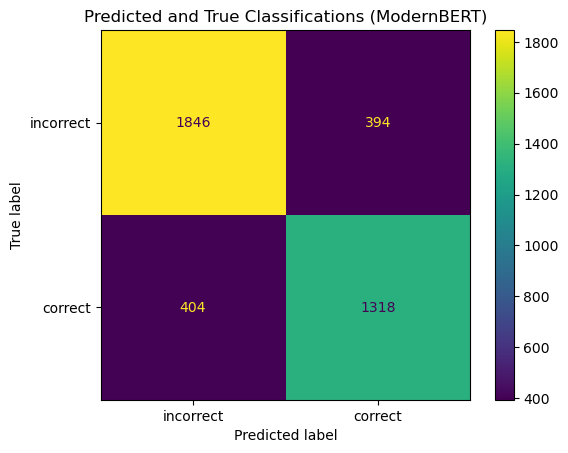


Classification Report:
                  precision    recall  f1-score   support

incorrect_answer       0.82      0.82      0.82      2240
  correct_answer       0.77      0.77      0.77      1722

        accuracy                           0.80      3962
       macro avg       0.80      0.79      0.79      3962
    weighted avg       0.80      0.80      0.80      3962



,text,true_label,predicted_label,raw_prediction
0,The Women's Haven of Tarrant County</s>\nAnswe...,1,1,1.000000
1,Tarrant county shelters</s>\nAnswer: The Women...,0,0,1.000000
2,Female's Safe House of Haven County</s>\nAnswe...,0,1,0.995602
3,California</s>\nAnswer: Texas,0,0,1.000000
4,Texas</s>\nAnswer: Texas,1,1,1.000000
...,...,...,...,...
3957,Gravity</s>Answer: Gravity caused dust and gas...,1,1,1.000000
3958,"Gravity formed the smallest moons, it also for...",1,1,0.999991
3959,Galxies</s>Answer: Gravity caused dust and gas...,0,0,0.999992
3960,Stars</s>Answer: Gravity caused dust and gas p...,0,0,0.999997


In [26]:
print("\nPrediction distribution:")
print(f"Unique predicted labels: {np.unique(pred_labels, return_counts=True)}")
print(f"Unique true labels: {np.unique(true_labels, return_counts=True)}")


if len(np.unique(pred_labels)) > 1 and len(np.unique(true_labels)) > 1:
    accuracy = metrics.accuracy_score(true_labels, pred_labels)
    precision = metrics.precision_score(true_labels, pred_labels, zero_division=0)
    recall = metrics.recall_score(true_labels, pred_labels, zero_division=0)
    f1 = metrics.f1_score(true_labels, pred_labels, zero_division=0)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    cm = metrics.confusion_matrix(true_labels, pred_labels)
    print(f"Confusion Matrix:\n{cm}")
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['incorrect', 'correct'])
    cm_display.plot()
    plt.title("Predicted and True Classifications (ModernBERT)")
    plt.show()
    
    print("\nClassification Report:")
    print(metrics.classification_report(true_labels, pred_labels, 
                                       target_names=['incorrect_answer', 'correct_answer']))
else:
    print("\nWARNING: Cannot calculate metrics - predictions or true labels are all the same value")
    print(f"All predictions: {pred_labels[0]}")
    print(f"Softmax scores: {scores[:5]}")

results_df = pd.DataFrame({
    'text': [ex['text'] for ex in ds['test']],
    'true_label': true_labels,
    'predicted_label': pred_labels,
    'softmax': scores,
})
results_df
# results_df.to_csv('modernbert_debug_results.csv')

In [28]:
results_df.text.iloc[3]

'California</s>\nAnswer: Texas'